In [52]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Test Specific Libraries
from sklearn.decomposition import PCA, FastICA
import cell2sentence as cs
from cell2sentence import tasks, CSData, CSModel
from cell2sentence.prompt_formatter import PromptFormatter
import ot
import cinemaot as co

# Huggingface
import torch
from transformers import AutoModelForCausalLM
from datasets import load_from_disk

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

import numpy as np
from scipy.stats import spearmanr

In [2]:
# load processed AnnData objects for human and mouse cells
human_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/human_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")
mouse_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/mouse_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")

In [3]:
human_restricted

AnnData object with n_obs × n_vars = 8569 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [4]:
human_restricted.X.data[:10]

array([0.08864673, 0.08864673, 0.16223046, 0.22513437, 0.08864673,
       0.2800693 , 0.16223046, 0.08864673, 0.16223046, 0.32882914],
      dtype=float32)

In [5]:
mouse_restricted

AnnData object with n_obs × n_vars = 1886 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [6]:
human_restricted.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0


In [7]:
# Ensure organism key is present for both human and mouse
if 'organism' not in human_restricted.obs:
    human_restricted.obs['organism'] = 'Homo sapiens'
if 'organism' not in mouse_restricted.obs:
    mouse_restricted.obs['organism'] = 'Mus musculus'

# Ensure cell_tyope key is present - slightly misworded
if 'cell_type' not in human_restricted.obs:
    human_restricted.obs['cell_type'] = human_restricted.obs['cell_types']
if 'cell_type' not in mouse_restricted.obs:
    mouse_restricted.obs['cell_type'] = mouse_restricted.obs['cell_types']

human_restricted.obs['cell_type'] = [x.lower() for x in human_restricted.obs['cell_type']]
mouse_restricted.obs['cell_type'] = [x.lower() for x in mouse_restricted.obs['cell_type']]

# Add species labels
human_restricted.obs['species'] = 'human'
mouse_restricted.obs['species'] = 'mouse'

In [8]:
human_restricted.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,organism,cell_type,species
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0,Homo sapiens,acinar,human


Data is already processed, no need to filter or normalize.
Using preprocessed data to embed cells.

In [9]:
c2s_save_dir = "/home/dor3/scratch/C2S_Files/c2s_api_testing"  # C2S dataset will be saved into this directory
human_c2s_save_name = "human_pancreas_tissue_c2s_embeddings_cinema_ot"  # This will be the name of our C2S dataset on disk
mouse_c2s_save_name = "mouse_pancreas_tissue_c2s_embeddings_cinema_ot"  # This will be the name of our C2S dataset on disk

In [10]:
# arrow_dir='./data/'
# # ensure the directory for Arrow datasets exists
# os.makedirs(arrow_dir, exist_ok=True)

# # paths to Arrow datasets
# arrow_path_human = os.path.join(arrow_dir, 'human_arrow')
# arrow_path_mouse = os.path.join(arrow_dir, 'mouse_arrow')

# convert AnnData to Arrow format and save
'''# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)'''
human_arrow_ds, human_vocab = CSData.adata_to_arrow(
    adata=human_restricted, 
    random_state=1234, 
    sentence_delimiter=' ',
    label_col_names=['cell_type', 'organism']  # NOTE: need this to keep 'organism' column in arrow dataset!
)

mouse_arrow_ds, mouse_vocab = CSData.adata_to_arrow(
    adata=mouse_restricted,
    random_state=1234, 
    sentence_delimiter=' ',
    label_col_names=['cell_type', 'organism']  # NOTE: need this to keep 'organism' column in arrow dataset!
)

WARN: more variables (12113) than observations (8569)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (12113) than observations (8569), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 8569/8569 [00:08<00:00, 1032.18it/s]
WARN: more variables (12113) than observations (1886)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (12113) than observations (1886), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 1886/1886 [00:02<00:00, 891.25it/s] 


In [11]:
human_arrow_ds  # NOTE: notice how 'organism' shows up now in the columns

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 8569
})

In [12]:
mouse_arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 1886
})

In [13]:
human_csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=human_arrow_ds, 
    vocabulary=human_vocab,
    save_dir=c2s_save_dir,
    save_name=human_c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 8569/8569 [00:00<00:00, 36572.23 examples/s]


In [14]:
mouse_csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=mouse_arrow_ds, 
    vocabulary=mouse_vocab,
    save_dir=c2s_save_dir,
    save_name=mouse_c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 1886/1886 [00:00<00:00, 23334.20 examples/s]


In [15]:
# Define CSModel object
# Huggingface link: https://huggingface.co/vandijklab/C2S-Pythia-410m-diverse-single-and-multi-cell-tasks

# Pull model from web, save model to disk
model_path = "vandijklab/C2S-Pythia-410m-diverse-single-and-multi-cell-tasks"
save_dir = "/home/dor3/palmer_scratch/C2S_Files_Daphne/c2s_api_testing/csmodel_tutorial_2"
save_name = "cell_embedding_prediction_pythia_410M_1"
csmodel = cs.CSModel(
    model_name_or_path=model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cpu


In [16]:
# Identify parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Define the directory to save the embeddings
embedded_cells_dir = os.path.join(parent_dir, "Embedded_Cells")
os.makedirs(embedded_cells_dir, exist_ok=True)

# Define file paths for human and mouse embeddings
human_embedding_path = os.path.join(embedded_cells_dir, "human_embeddings.npy")
mouse_embedding_path = os.path.join(embedded_cells_dir, "mouse_embeddings.npy")

# Function to save embeddings
def save_embeddings(embedding, filepath):
    np.save(filepath, embedding)
    print(f"Saved embeddings to {filepath}")

# Function to load embeddings
def load_embeddings(filepath):
    embedding = np.load(filepath)
    print(f"Loaded embeddings from {filepath}")
    return embedding


In [17]:
# Check if embeddings already exist
if os.path.exists(human_embedding_path): 
    # Load the embeddings from files
    embedded_human_cells = load_embeddings(human_embedding_path)

else:
    # Perform embedding using the GPU (with Cell2Sentence)
    # Embed human cells
    embedded_human_cells = tasks.embed_cells(
        csdata=human_csdata,
        csmodel=csmodel,
        n_genes=1000,
        inference_batch_size=1
    )
    # Save the embeddings to files so we don't need to use GPU next time
    save_embeddings(embedded_human_cells, human_embedding_path)

if os.path.exists(mouse_embedding_path):
    # Load the embeddings from files
    embedded_mouse_cells = load_embeddings(mouse_embedding_path)
else:
    # Perform embedding using the GPU (with Cell2Sentence)
    # Embed mouse cells
    embedded_mouse_cells = tasks.embed_cells(
        csdata=mouse_csdata,
        csmodel=csmodel,
        n_genes=1000,
        inference_batch_size=1
    )
    # Save the embeddings to files so we don't need to use GPU next time
    save_embeddings(embedded_mouse_cells, mouse_embedding_path)

Loaded embeddings from /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Embedded_Cells/human_embeddings.npy
Loaded embeddings from /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Embedded_Cells/mouse_embeddings.npy


In [18]:
human_c2s_embed_matrix = embedded_human_cells  # This should be shape [num_cells, num_genes]
# Define an observation dataframe
obs_df = human_restricted.obs.copy()  # Just copy obs df from original anndata object, since cells are the same

# Define a variables dataframe
col_names = ["dim_{}".format(idx) for idx in range(human_c2s_embed_matrix.shape[1])]
var_df = pd.DataFrame({
    "col_names": col_names
}, index=col_names)

# Define AnnData object with C2S embeddings
human_adata = anndata.AnnData(X=human_c2s_embed_matrix, obs=obs_df, var=var_df)

In [19]:
mouse_c2s_embed_matrix = embedded_mouse_cells  # This should be shape [num_cells, num_genes]
# Define an observation dataframe
obs_df = mouse_restricted.obs.copy()  # Just copy obs df from original anndata object, since cells are the same

# Define a variables dataframe
col_names = ["dim_{}".format(idx) for idx in range(mouse_c2s_embed_matrix.shape[1])]
var_df = pd.DataFrame({
    "col_names": col_names
}, index=col_names)

# Define AnnData object with C2S embeddings
mouse_adata = anndata.AnnData(X=mouse_c2s_embed_matrix, obs=obs_df, var=var_df)

In [20]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_adata, mouse_adata], merge='same')
sc.tl.pca(combined_adata)


In [21]:
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

In [22]:
# Create the "plots" directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


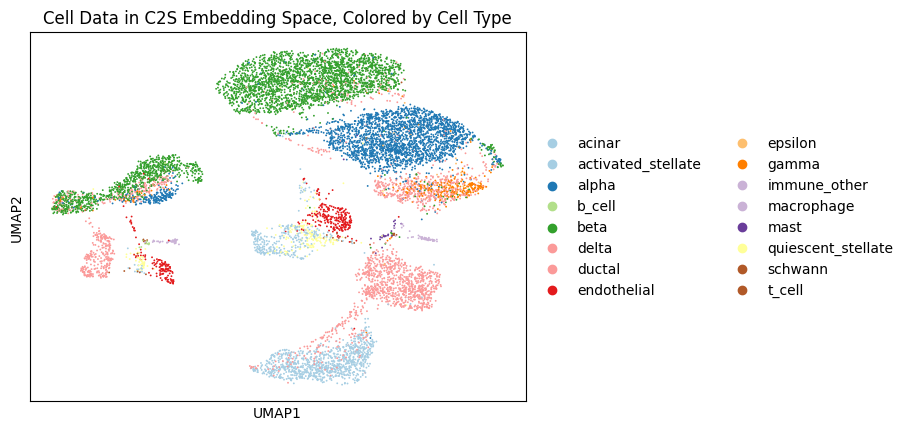

UMAP plot saved to plots/umap_daphne2.png


In [23]:
# Optional: Visualize the optimal transport pairs on UMAP
#sc.pp.neighbors(combined_adata, use_rep='X_pca')
#sc.tl.umap(combined_adata)

# Visualize UMAP
umap_species_plot_path = os.path.join(plots_dir, "umap_daphne2.png")
fig = sc.pl.umap(combined_adata, color=['cell_type'], return_fig=True, s=7, title="Cell Data in C2S Embedding Space, Colored by Cell Type", palette='Paired')
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_species_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_species_plot_path}")


In [24]:
def optimal_transport_pairing(combined_adata):
    """
    Compute the optimal transport (OT) pairing between human and mouse cells using a combined AnnData object.
    
    Parameters:
    - combined_adata: AnnData object containing concatenated human and mouse data
                     (created using anndata.concat([human_adata, mouse_adata], merge='same'))
                     Must contain a 'species' column in .obs with values "human" and "mouse"
    
    Returns:
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells
    - ot_matrix: The optimal transport matrix
    """
    # Verify the data structure
    if 'species' not in combined_adata.obs:
        raise ValueError("Combined AnnData object must have 'species' column in .obs")
    
    # Split indices for human and mouse cells
    human_mask = combined_adata.obs['species'] == 'human'
    mouse_mask = combined_adata.obs['species'] == 'mouse'
    
    if not (human_mask.any() and mouse_mask.any()):
        raise ValueError("Species column must contain both 'human' and 'mouse' values")
    
    human_indices = np.where(human_mask)[0]
    mouse_indices = np.where(mouse_mask)[0]
    
    # Extract the expression matrices
    if isinstance(combined_adata.X, np.ndarray):
        X = combined_adata.X
    else:
        X = combined_adata.X.toarray()
    
    X_human = X[human_mask]
    X_mouse = X[mouse_mask]
    
    # Compute the cost matrix using Euclidean distance
    cost_matrix = ot.dist(X_human, X_mouse, metric='euclidean')
    
    # Visualize the cost matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cost_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Euclidean Distance')
    plt.title('Cost Matrix (Euclidean Distance)')
    plt.xlabel('Mouse Cells')
    plt.ylabel('Human Cells')
    plt.show()
    
    # Uniform distribution over human and mouse cells
    human_distribution = np.ones(X_human.shape[0]) / X_human.shape[0]
    mouse_distribution = np.ones(X_mouse.shape[0]) / X_mouse.shape[0]
    
    # Compute the optimal transport matrix using the Earth Mover's Distance
    ot_matrix = ot.emd(human_distribution, mouse_distribution, cost_matrix)
    
    # Find the optimal pairs based on the transport plan
    paired_indices = []
    for i, human_idx in enumerate(human_indices):
        mouse_relative_idx = np.argmax(ot_matrix[i])
        mouse_absolute_idx = mouse_indices[mouse_relative_idx]
        paired_indices.append((human_idx, mouse_absolute_idx))
    
    return paired_indices, ot_matrix

In [25]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_adata, mouse_adata], merge='same')

In [26]:
combined_adata

AnnData object with n_obs × n_vars = 10455 × 1024
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    var: 'col_names'

In [27]:
sc.pp.highly_variable_genes(combined_adata, subset=False,n_top_genes=2000,batch_key='batch_sample')
sc.tl.pca(combined_adata,use_highly_variable=True)
sc.external.pp.harmony_integrate(combined_adata,'batch_sample',basis='X_pca',adjusted_basis='X_pca_harmony_library')

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:279: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:279: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_v

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:279: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:279: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
2024-11-30 00:46:36,487 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-30 00:46:42,941 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-30 00:46:43,031 - harmonypy - INFO - Iteration 1 of 10
2024-11-30 00:46:48,419 - harmonypy - INFO - Iteration 2 of 10


In [28]:
combined_adata

AnnData object with n_obs × n_vars = 10455 × 1024
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    var: 'col_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony_library'
    varm: 'PCs'

In [29]:
sc.pp.neighbors(combined_adata, use_rep="X_pca_harmony_library")

In [30]:
combined_adata.obs.tail()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,organism,cell_type,species
mouse2_lib3.final_cell_0391,TGATTGCACGC-CATTTGTT,mouse2_lib3.final_cell_0391,beta,GSM2230762_mouse2_umifm_counts,805,804,2114.0,0.0,0.0,Mus musculus,beta,mouse
mouse2_lib3.final_cell_0392,TAACTACT-AAGTAATC,mouse2_lib3.final_cell_0392,beta,GSM2230762_mouse2_umifm_counts,778,778,1864.0,0.0,0.0,Mus musculus,beta,mouse
mouse2_lib3.final_cell_0393,TGACCTGTTAT-TGATGCCC,mouse2_lib3.final_cell_0393,ductal,GSM2230762_mouse2_umifm_counts,1010,1010,1714.0,0.0,0.0,Mus musculus,ductal,mouse
mouse2_lib3.final_cell_0394,TGAGTAATCCC-AACCCTTG,mouse2_lib3.final_cell_0394,quiescent_stellate,GSM2230762_mouse2_umifm_counts,888,887,1501.0,0.0,0.0,Mus musculus,quiescent_stellate,mouse
mouse2_lib3.final_cell_0395,AGCACCTCT-ATTCCTTG,mouse2_lib3.final_cell_0395,ductal,GSM2230762_mouse2_umifm_counts,860,860,1591.0,0.0,0.0,Mus musculus,ductal,mouse


In [31]:
sc.tl.umap(combined_adata)

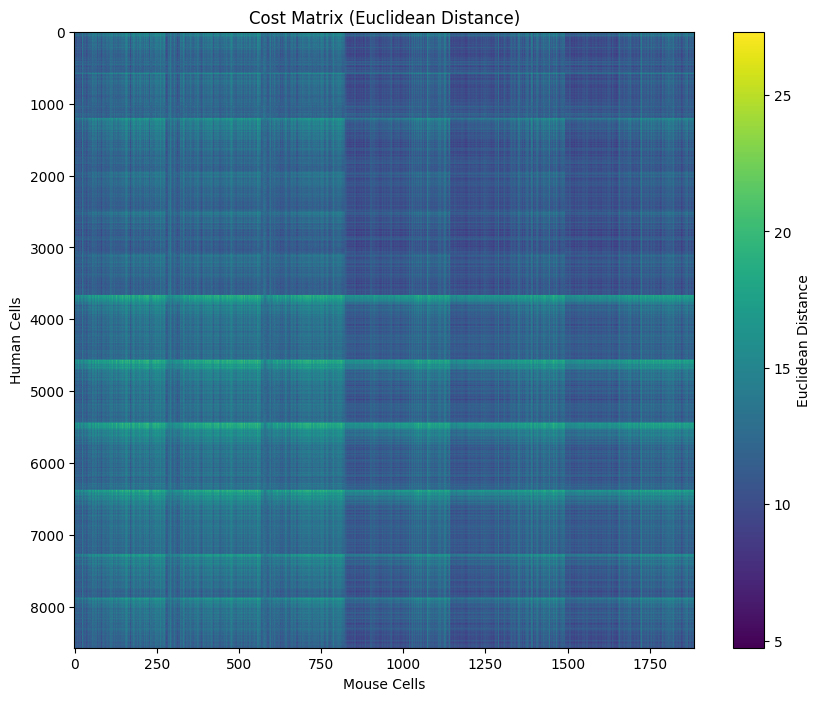

/home/dor3/.local/lib/python3.8/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.


8569

In [32]:
paired_indices, ot_matrix = optimal_transport_pairing(combined_adata)
len(paired_indices)

In [33]:
print(paired_indices[0])
print(paired_indices[1])
print(paired_indices[2])

(0, 8569)
(1, 8569)
(2, 8569)


In [34]:
# Is the default 0? What happens in this OT method that makes so many of them match to 0?
print(paired_indices[:50])

[(0, 8569), (1, 8569), (2, 8569), (3, 8569), (4, 8569), (5, 8569), (6, 9138), (7, 8569), (8, 8569), (9, 8569), (10, 8569), (11, 8569), (12, 9954), (13, 9796), (14, 10110), (15, 8572), (16, 9579), (17, 8569), (18, 8861), (19, 9580), (20, 9520), (21, 10403), (22, 9144), (23, 10061), (24, 9873), (25, 10125), (26, 9406), (27, 8933), (28, 10428), (29, 10090), (30, 9972), (31, 9454), (32, 10184), (33, 9490), (34, 10160), (35, 8569), (36, 8590), (37, 10243), (38, 9529), (39, 9478), (40, 9962), (41, 9815), (42, 9889), (43, 9962), (44, 10124), (45, 9682), (46, 8569), (47, 9142), (48, 8979), (49, 9493)]


# The mouse indices need to be normalized.

Right now, the paired indices represent the pairings of the human -> mouse cells within the concatted data. This means that the mouse indices begin at the value of human_restricted.n_obs. Instead, we want mouse indices to begin at 0, as they do in the original raw mouse data we loaded in at the top of this notebook.

In [35]:
# Sanity check! The number of indices should be the same as the number of human cells (because we are transporting human cells)
print(f"THe number of indices should be the same number of human cells: {len(paired_indices) == human_restricted.n_obs}")

THe number of indices should be the same number of human cells: True


In [36]:
normalized_paired_indices = []
for (h, m) in paired_indices:
    normalized_paired_indices.append((h, m-human_restricted.n_obs))


In [ ]:
# Sanity check
max_mouse_index = 0
for (h, m) in normalized_paired_indices:
    if m > max_mouse_index:
        max_mouse_index = m

# Sanity check! The max mouse index should be within the valid range of normalized mouse indices
print(f"The max mouse index is within the valid range of normalized mouse indices: {max_mouse_index < mouse_restricted.n_obs}")

1885


True

# Now that we have validated our normalization of the mouse data, assign normalized data to paired_indices

In [38]:
paired_indices = normalized_paired_indices

In [39]:
# Create the "plots" directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


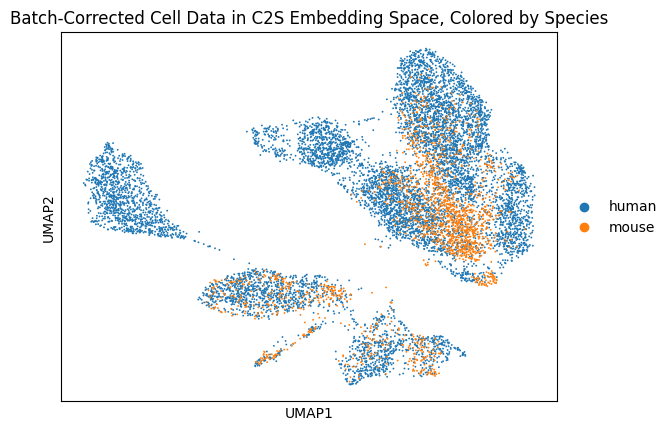

UMAP plot saved to plots/umap_harmonized_cell_embeddings_colored_by_species.png


In [40]:
# Optional: Visualize the optimal transport pairs on UMAP
# sc.pp.neighbors(combined_adata, use_rep='X_pca')
# sc.tl.umap(combined_adata)

# Visualize UMAP
umap_species_plot_path = os.path.join(plots_dir, "umap_harmonized_cell_embeddings_colored_by_species.png")
fig = sc.pl.umap(combined_adata, color=['species'], return_fig=True, s=7, title="Batch-Corrected Cell Data in C2S Embedding Space, Colored by Species")
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_species_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_species_plot_path}")


/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


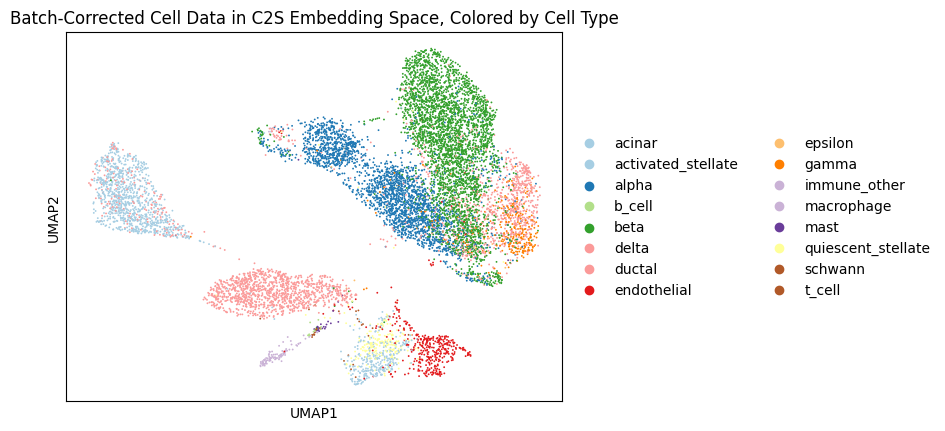

UMAP plot saved to plots/umap_harmonized_cell_embeddings_colored_by_cell_type.png


In [41]:
# Optional: Visualize the optimal transport pairs on UMAP
# sc.pp.neighbors(combined_adata, use_rep='X_pca')
# sc.tl.umap(combined_adata)

# Visualize UMAP
umap_cell_type_plot_path = os.path.join(plots_dir, "umap_harmonized_cell_embeddings_colored_by_cell_type.png")
cmap = plt.get_cmap('magma')
fig = sc.pl.umap(combined_adata, color=['cell_type'], return_fig=True, palette="Paired", s=7, title="Batch-Corrected Cell Data in C2S Embedding Space, Colored by Cell Type")
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_cell_type_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_cell_type_plot_path}")

# Plot classic OT pairs on a umap, showing cell_type and species plots.

In [42]:
def plot_joint_umap_with_pairs(
    human_mouse_joint_adata,
    num_human_cells,
    paired_indices,
    color_label,
    save_path,
    title,
    cell_type=None,
    adata_human=None,
    adata_mouse=None,
    filter_by_human=True  # if True, shows which mouse cells all human cells map to, else vice versa
):
    """
    Create a joint UMAP of human and mouse AnnData objects and plot the lines connecting paired cells.

    Parameters:
    - human_mouse_adata: AnnData object for human and mouse cells.
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    - color_label: The column in `obs` to color by.
    - save_path: Path to save the plot.
    - cell_type: (Optional) Filter pairs by specific cell type.
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.
    - filter_by_human: True to filter by human cell type, False to filter by mouse cell type.
    """
    # Ensure the "plots" directory exists
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    # Construct the full save path
    full_save_path = os.path.join(plots_dir, save_path)
    
    # Ensure UMAP is computed and stored in the AnnData object
    if 'X_umap' not in human_mouse_joint_adata.obsm:
        sc.pp.neighbors(human_mouse_joint_adata)
        sc.tl.umap(human_mouse_joint_adata)
    
    if color_label=='species':
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            s=7,
            title=title,
        )
    else:
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            palette="Paired",
            s=7,
            title=title,
        )

    # Extract the UMAP coordinates
    umap_human = human_mouse_joint_adata.obsm['X_umap'][:num_human_cells, :]
    umap_mouse = human_mouse_joint_adata.obsm['X_umap'][num_human_cells:, :]

    # Filter the paired indices based on the specified cell type, if provided
    if cell_type:
        if filter_by_human:
            human_cell_type_mask = adata_human.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if human_cell_type_mask[human_idx]
            ]
        else:
            mouse_cell_type_mask = adata_mouse.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if mouse_cell_type_mask[mouse_idx]
            ]
    else:
        # Use all pairs if no cell type is specified
        filtered_pairs = paired_indices

    # Plot lines connecting paired human and mouse cells
    for human_idx, mouse_idx in filtered_pairs:
        # Get the UMAP coordinates of the paired human and mouse cells
        human_coord = umap_human[human_idx]
        mouse_coord = umap_mouse[mouse_idx]
        
        # Plot a light gray line connecting the paired cells
        plt.plot([human_coord[0], mouse_coord[0]], 
                 [human_coord[1], mouse_coord[1]], 
                 color='lightgray', linewidth=0.6, alpha=0.2, linestyle="--")

    # Save the plot
    plt.savefig(full_save_path, facecolor="white", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    # Print confirmation
    print(f"Plot saved to {full_save_path}")

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


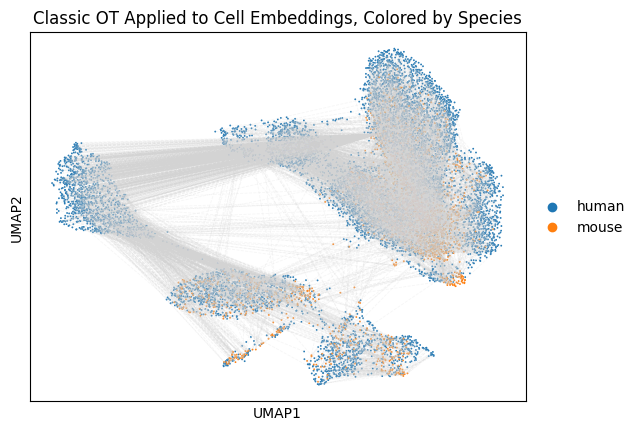

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Classic_OT_on_Cell_Embeddings/plots/classic_ot_paired_harmonized_cell_embeddings_species.png


In [43]:
color_label='species'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_adata.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="classic_ot_paired_harmonized_cell_embeddings_species.png", 
    title=f"Classic OT Applied to Cell Embeddings, Colored by {str.capitalize(color_label)}",
    adata_human=human_adata, 
    adata_mouse=mouse_adata
)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


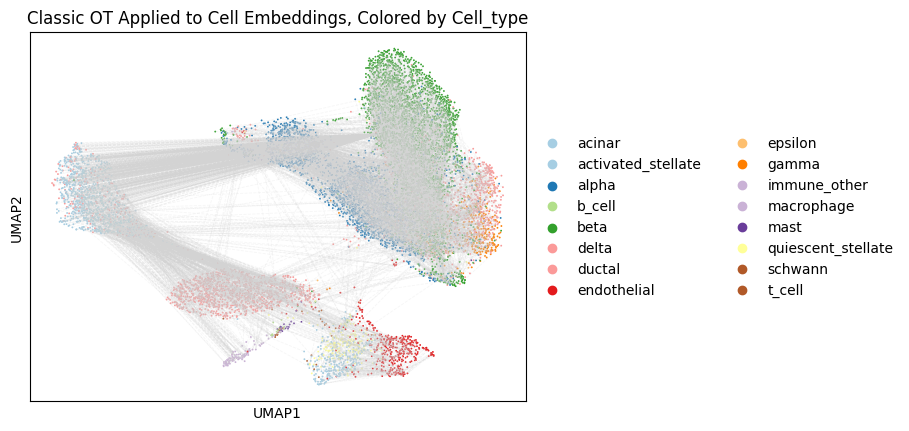

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Classic_OT_on_Cell_Embeddings/plots/classic_ot_paired_harmonized_cell_embeddings_cell_type.png


In [44]:
color_label='cell_type'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_adata.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="classic_ot_paired_harmonized_cell_embeddings_cell_type.png", 
    title=f"Classic OT Applied to Cell Embeddings, Colored by {str.capitalize(color_label)}",
    adata_human=human_adata, 
    adata_mouse=mouse_adata
)

In [45]:
# Extract true labels
human_labels = [x.lower() for x in human_restricted.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_restricted.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Combine unique labels for human and mouse separately
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']


In [46]:
# Reorder all_labels to include common labels first (so our heatmap has a stronger diagonal)
def common_element(list1, list2):
    return [element for element in list1 if element in list2]
common_labels = common_element(unique_human_labels, unique_mouse_labels)
print(common_labels)

for i in all_labels:
    if i not in common_labels:
        common_labels.append(i)

all_labels = common_labels

['activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'gamma', 'macrophage', 'quiescent_stellate', 'schwann', 't_cell']


In [47]:
cm_path = "/home/dor3/cell2sentence/cross_species/Classic_OT_on_Cell_Embeddings/plots/classic_ot_embedded_cells_confusion_matrix.png"
# Generate confusion matrix with consistent labels
cm = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df = DataFrame(cm, index=all_labels, columns=all_labels)

# Compute row and column sums
row_sums = cm_df.sum(axis=1)
col_sums = cm_df.sum(axis=0)
non_zero_rows = row_sums != 0
non_zero_cols = col_sums != 0
filtered_cm_df = cm_df.loc[non_zero_rows, non_zero_cols]
percentage_df = filtered_cm_df.div(filtered_cm_df.sum(axis=1), axis=0) * 100

# Custom annotation function - only show values above threshold
def annot_formatter(val):
    if val > 1:  # Only show values above 1%
        return f'{val:.1f}' if val < 10 else f'{val:.1f}'  # One decimal for small values
    return ''

# Create annotation matrix
annot_matrix = percentage_df.applymap(annot_formatter)

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))

# Create custom colormap with better differentiation for small values
cmap = sns.color_palette("Greens", as_cmap=True)

heatmap = sns.heatmap(percentage_df,
            annot=annot_matrix,
            fmt='',
            cmap=cmap,
            linewidths=0.5,
            square=True,  # Make cells square
            cbar_kws={'label': 'Percentage (%)',
                     'shrink': .8},  # Customize colorbar
            annot_kws={'size': 8},  # Adjust annotation font size
            vmin=0,
            vmax=100)  # Fix color scale from 0 to 100%

# Get the colorbar and add gray outline
colorbar = heatmap.collections[0].colorbar
colorbar.outline.set_edgecolor('gray')
colorbar.outline.set_linewidth(0.7)

# Rotate axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add descriptive title and labels
plt.title('Human-Mouse Cell Type Correspondence (%)', 
          pad=20,
          fontsize=16,
          fontweight='bold')

plt.xlabel('Mouse Cell Types', fontsize=15, labelpad=12)
plt.ylabel('Human Cell Types', fontsize=15, labelpad=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot using matplotlib
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Enhanced confusion matrix plot saved to {cm_path}")


Enhanced confusion matrix plot saved to /home/dor3/cell2sentence/cross_species/Classic_OT_on_Cell_Embeddings/plots/classic_ot_embedded_cells_confusion_matrix.png


## Now, we need to score the human-mouse mapping.

### Raw Matching Score: This first metric calculates the percentage of human cells that are matched to mouse cells of the corresponding cell type, considering only shared cell types between species. While straightforward, this metric may be biased toward highly abundant cell types in the dataset (like beta cells), potentially overlooking the methods that find correspondences among a broader array of shared cell types.

In [48]:
''' Calculate Raw Matching Score '''

# Filter percentage_df to only include the rows and columns of the shared cells
filtered_df = filtered_cm_df.iloc[:11, :11]
filtered_df

# Sum of diagonal values (where row=column)
diagonal_sum = filtered_df.values[np.diag_indices(11)].sum()

# Sum of all values in dataframe  
total_sum = filtered_df.values.sum()

# Calculate raw matching score
raw_matching_score = diagonal_sum / float(total_sum)

### Balanced Cell Type Score: To address the potential bias in raw matching, we compute the average matching accuracy per cell type. This approach gives equal weight to each shared cell type regardless of its abundance in the dataset, providing a more balanced assessment of the method's performance across different cell populations.

In [49]:
''' Calculate Balanced Cell Type Score '''
# Filter confusion matrix of cell counts to only include rows and columns of the shared cell types
filtered_df = percentage_df.iloc[:11, :11]

# Get diagonal values 
diagonal = np.diag(percentage_df)

# Calculate mean of diagonal (average accuracy per cell type)
balanced_accuracy = (np.mean(diagonal) * .01)


### Gene Expression Correlation Score: This measure calculates the correlation between matched cells’ expression profiles for homologous genes. Higher correlation suggests better matching, regardless of cell type name. 

In [50]:
''' Calculate Gene Expression Correlation Score '''

def compute_correlation_score(human_data, mouse_data, paired_indices, homolog_genes):

   """
    Compute correlation-based score for matched cell pairs.
    
    Args:
    human_data: DataFrame of human gene expression (cells x genes)
    mouse_data: DataFrame of mouse gene expression (cells x genes)
    paired_indices: List of matched cell pairs from OT method's transport plan
    homolog_genes: List of homologous genes shared between species
    
    Returns:
    float: Average correlation score across all matched pairs

   """
   correlations = []
   for h_idx, m_idx in paired_indices:
       human_expr = human_data.iloc[h_idx][homolog_genes]
       mouse_expr = mouse_data.iloc[m_idx][homolog_genes]
       corr, _ = spearmanr(human_expr, mouse_expr)
       correlations.append(corr)
   
   return np.mean(correlations)

# Extract homologous genes from AnnData object
homolog_genes = human_restricted.var_names.tolist()

# Extract expression data
human_data = pd.DataFrame(human_restricted.X.toarray(),  # Convert sparse to dense
            columns=homolog_genes,
            index=human_restricted.obs_names)

mouse_data = pd.DataFrame(mouse_restricted.X.toarray(),  # Convert sparse to dense 
            columns=homolog_genes,
            index=mouse_restricted.obs_names)


In [ ]:
gene_expression_correlation_score = compute_correlation_score(human_data, mouse_data, paired_indices, homolog_genes)

In [54]:
print(f"Raw matching score: {raw_matching_score}")
print(f"Balanced cell type score: {balanced_accuracy}")
print(f"Gene expression correlation score: {gene_expression_correlation_score}")

Raw matching score: 0.555761835300358
Balanced cell type score: 0.429168740075944
Gene expression correlation score: 0.2112167242097001
